In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from prototype_data import get_dataset
from prototype_runs import Experiment
#from prototype_plots import Report, plot2D, transform_label, plot_elbow_curve
%run prototype_plots.py
random_state=0
dataset = 'mnist'
train_size = 500
N = n_classes = 10
random_state=0

/mnt/Data/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
inpath = dataset + '_hparams'
results_path = os.path.join("prototype_results", inpath)
os.makedirs(results_path, exist_ok=True)
print(results_path)

prototype_results/mnist_hparams


# Study of hyper parameters - Cluster and classification of inceptionV3 features

## Dataset

Experiments on one common episode with 10 classes to explore hyper parameters and get a feel of their sensibility.

Bellow we sample an episode on the data.

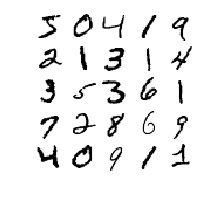

In [4]:
dataset_obj = get_dataset(dataset, random_state)
X_imgs, X, y = dataset_obj.gen_data(N=N, plot=True)
skf, skf_cv = dataset_obj.splitters(train_size=train_size, cv_repeats=5)
train, test = list(skf.split(X, y))[0]
plt.gcf().set_size_inches(5,3)
plt.savefig(os.path.join(results_path, dataset+'_examples.eps'), dpi=300)

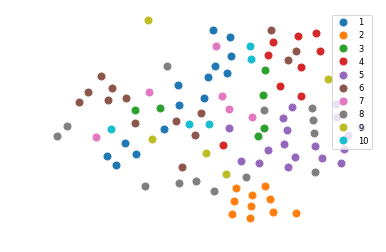

In [5]:
np.random.seed(0)
plot2D(X, y, method='tsne')
plt.title('')
#plt.tick_params(length=0,labelsize=0)
plt.axis("off")
fig = plt.gcf()
fig.set_size_inches(6,4)
plt.legend(loc='best', fontsize='small')
plt.savefig(os.path.join(results_path,dataset+"_TSNE_example.eps"))

### Elbow curve

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
plt.figure()
out = []
normalizers = [False, MinMaxScaler, StandardScaler]
for i, normalize in enumerate(normalizers):
    o = plot_elbow_curve(
        X[train], y[train], n_clusters=np.array([5] + list(range(10,80,10))),
        cv=skf_cv, normalize=normalize, random_state=random_state,
        plot=False)
    out.append(o)

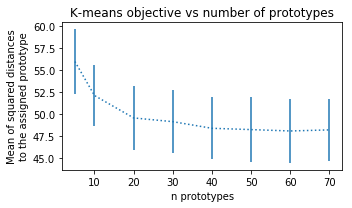

In [8]:
plt.figure(figsize=(5,3))
plt.errorbar(*out[1], linestyle=':')
plt.title('K-means objective vs number of prototypes')
plt.xlabel('n prototypes')
plt.ylabel('Mean of squared distances\nto the assigned prototype')
plt.tight_layout()
plt.savefig(os.path.join(results_path, dataset+'_elbow.pdf'), dpi=300)

### Normalizations

Text(0.5,0.98,'K-means objective vs number of prototypes')

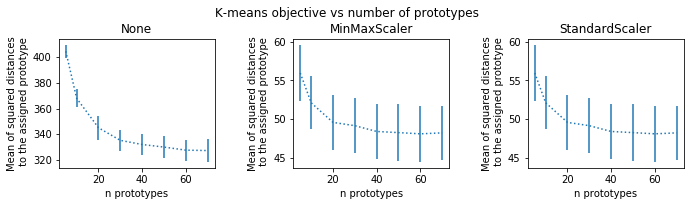

In [9]:
plt.figure(figsize=(10,3))
for i, normalize in enumerate(normalizers):
    plt.subplot(1,3,i+1)
    if not normalize:
        label = 'None'
    else:
        label = normalize.__name__.split('.')[-1]
    plt.errorbar(*out[i], linestyle=':', label=label)
    plt.title(label)
    plt.xlabel('n prototypes')
    plt.ylabel('Mean of squared distances\n to the assigned prototype')
    #plt.legend(loc='best')
plt.tight_layout(pad=2)
plt.suptitle('K-means objective vs number of prototypes')

2.253333333333333 hours total


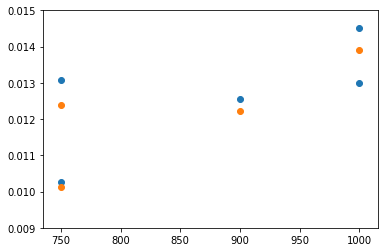

In [10]:
# time spent on each experiemnt bellow, for register
exp = ['base', 'cat', 'class_weight', 'shortcut', 'both']
n_fits = np.array([1000, 1000, 750, 750, 900])
t_l1 = np.array([13,14.5,7.7,9.8,11.3]) # min
t_l2 = np.array([37.1, 13.9, 7.6, 9.3, 11.0]) # min
plt.scatter(n_fits, t_l1/n_fits)
plt.scatter(n_fits, t_l2/n_fits)
plt.ylim((0.009,0.015))
print((t_l1.sum()+t_l2.sum())/60, 'hours total')

## Base model on 10 classes

Exploring hyperparams on a large interval.

When plotting the closest images, also annotated information on closest and farthest training point (attributed to that prototype). When no point was atributed (indicated by 0 pts), distances correspond to closest and farthest point over all training points.

In [11]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_base_models'),
        model_list=['l1_plain','l2_plain'],
        n_Cs=10, Cs_lim=(-3,8),
        n_n_clusters=10, n_clusters_lim=(1,5),
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_plain', 'l2_plain'], 'path': './prototype_results/mnist_hparams/analysing_base_models', 'dataset': <prototype_data.Mnist object at 0x7fcfae557048>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fcfb0359e80>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 10, 'Cs_lim': (-3, 8), 'n_n_clusters': 10, 'n_clusters_lim': (1, 5), 'n_class_weights': 3, 'class_weight_lim': (0.0, 2.0), 'n_shortcut': 1, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/mnist_hparams/analysing_base_models/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_plain', 'l2_plain']
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   32.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 11.3min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed: 14.3min finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   32.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  6.3min
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergen

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

### Train split 0

In [12]:
reportl1 = Report('analysing_base_models', models, model='l1_plain', split=0, splitter=skf, N=N, directory=results_path)
reportl2 = Report('analysing_base_models', models, model='l2_plain', split=0, splitter=skf, N=N, directory=results_path)

In [13]:
for train, test in skf.split(X, y):
    print('l1',reportl1.model.score(X[test],y[test]),'l2',reportl2.model.score(X[test],y[test]))

l1 0.7577 l2 0.7738


#### L1 penalty

In [14]:
reportl1.wc_stats()
reportl1.report(X,y)

Wc sparsity @ tol=0.1 0.01200000000000001
Wc mean:  0.011341298614364642 std:  4.7500399742464685
best Params {'classify__C': 1291.5496650148852, 'classify__penalty': 'l1', 'classify__shortcut': 0.0, 'classify__solver': 'saga', 'classify__tol': 0.1, 'classify__use_shortcut': False, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 50}
mean acuracy of best cv model:  0.6957145828999376
best model train accuracy:  0.792
holdout test accuracy:  0.7577


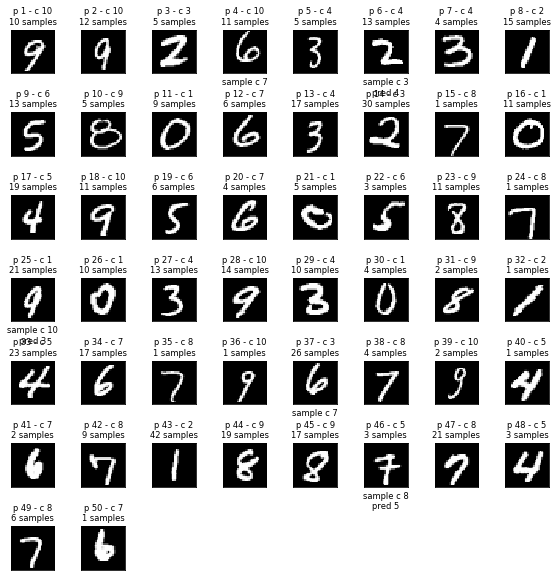

In [15]:
reportl1.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.tight_layout()

proto per class:  [5.76767174 3.02831422 3.70671397 5.92824964 5.1338329  3.10765989
 5.14757242 6.97333701 4.77094646 6.43570175]


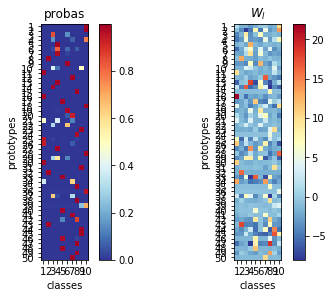

In [16]:
reportl1.visualize_weights()

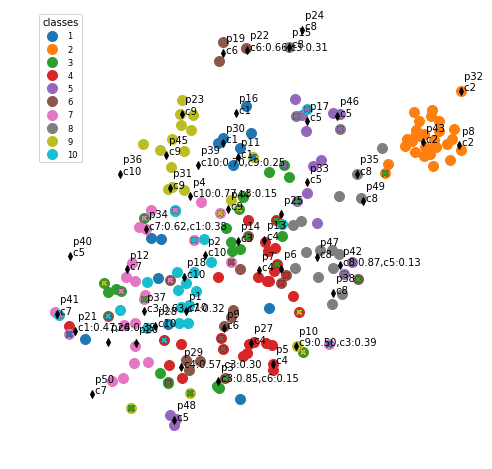

In [17]:
np.random.seed(0)
reportl1.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False)
fig = plt.gcf()
fig.set_size_inches(8,8)
reportl1.savefig('plot2D_tsne.eps')

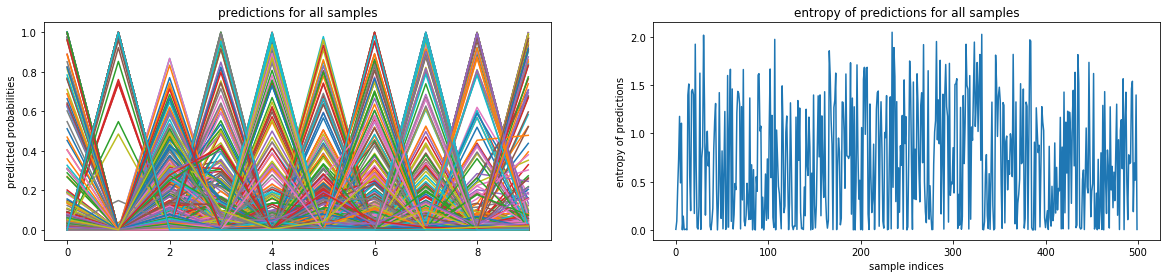

In [18]:
reportl1.entropy_per_sample(X,y)
plt.gcf().set_size_inches(20,4)

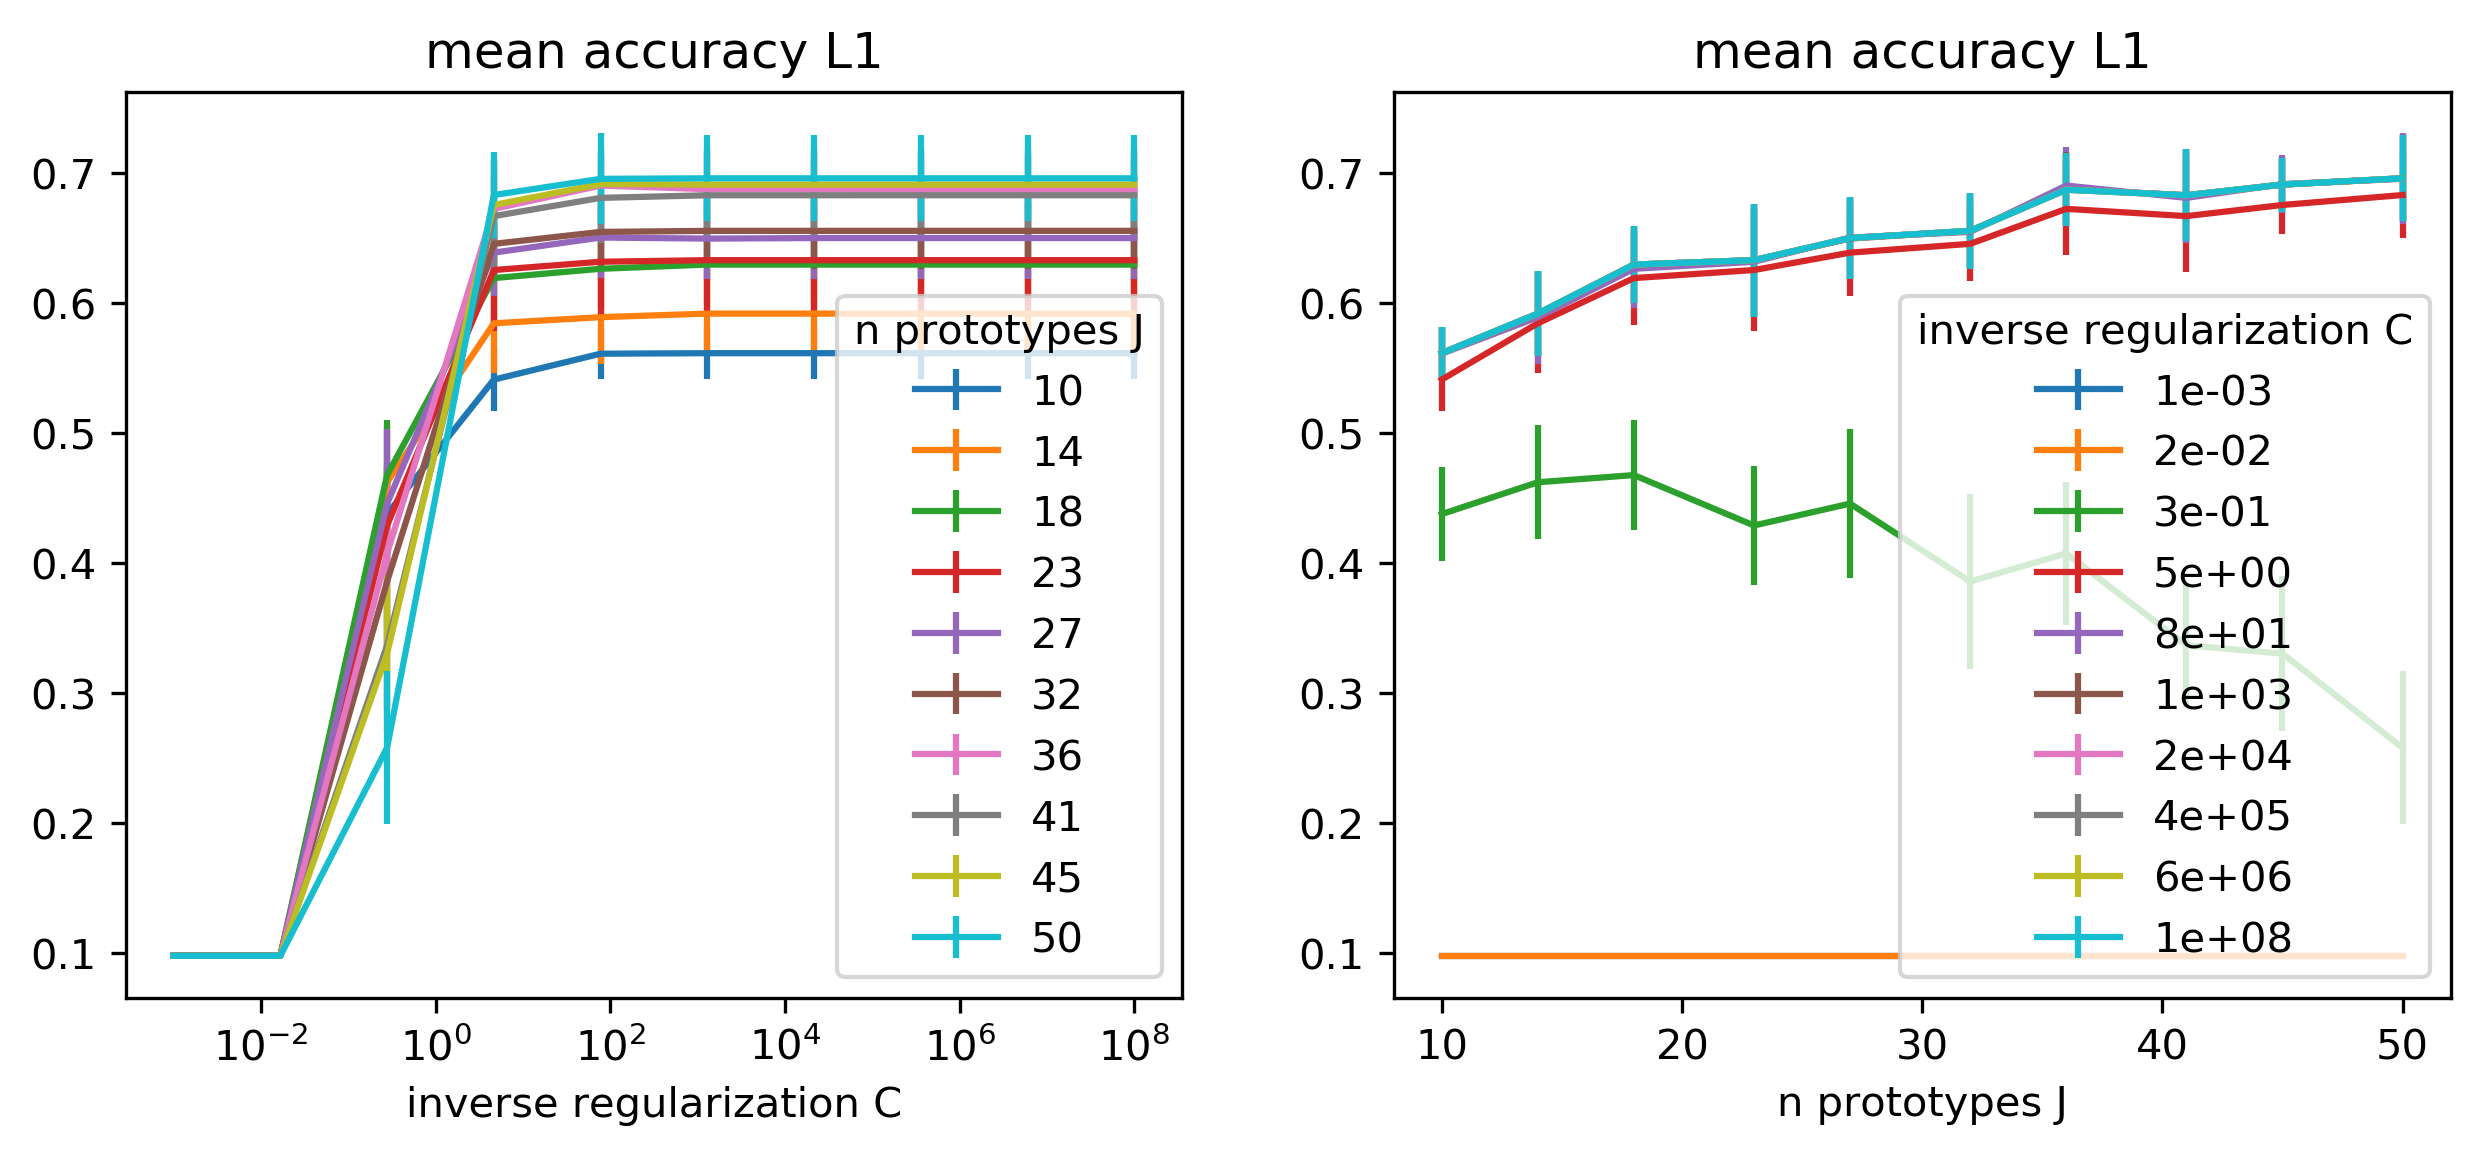

In [19]:
reportl1.main_parameter_grids()

#### L2 penalty

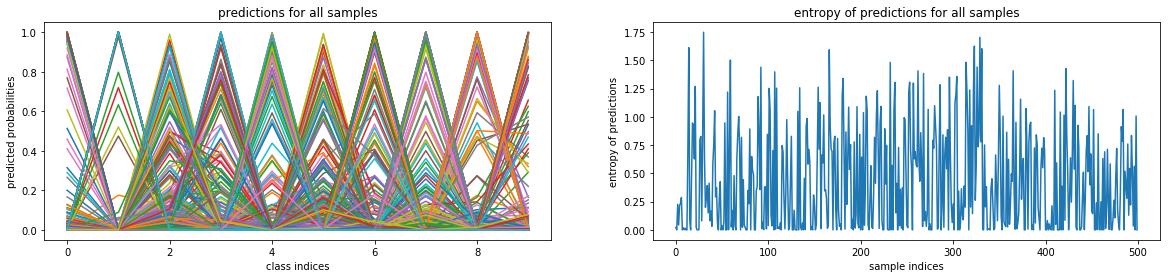

In [20]:
reportl2.entropy_per_sample(X,y)
plt.gcf().set_size_inches(20,4)

In [21]:
reportl2.wc_stats()
reportl2.report(X,y)

Wc sparsity @ tol=0.1 0.00666666666666671
Wc mean:  6.1896167203990946e-15 std:  13.496297157684765
best Params {'classify__C': 1291.5496650148852, 'classify__penalty': 'l2', 'classify__shortcut': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': False, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 45}
mean acuracy of best cv model:  0.7056440127378343
best model train accuracy:  0.886
holdout test accuracy:  0.7738


proto per class:  [6.71910283 3.18568066 2.23863099 4.86079422 5.2626076  3.92591555
 5.53787803 3.53145216 4.29592893 5.44200903]


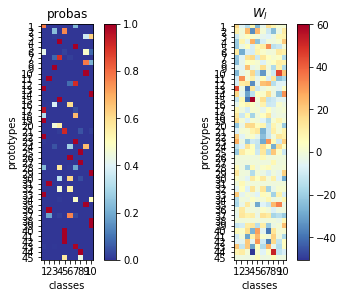

In [22]:
reportl2.visualize_weights()

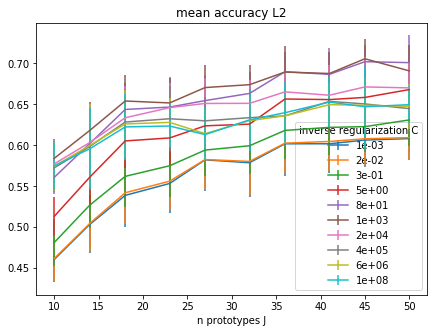

In [23]:
_ = reportl2.parameter_grid(index=['param_cluster__n_clusters'],
            columns=['param_classify__C'], fix='all')
plt.gcf().set_size_inches(7,5)
reportl2.savefig('n_clusters_C.eps')

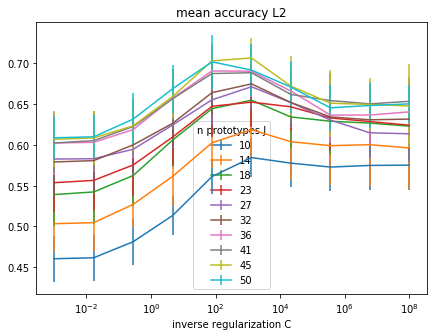

In [24]:
_ = reportl2.parameter_grid(index=['param_classify__C'],
            columns=['param_cluster__n_clusters'], fix='all')
plt.gcf().set_size_inches(7,5)
reportl2.savefig('C_n_clusters.eps')

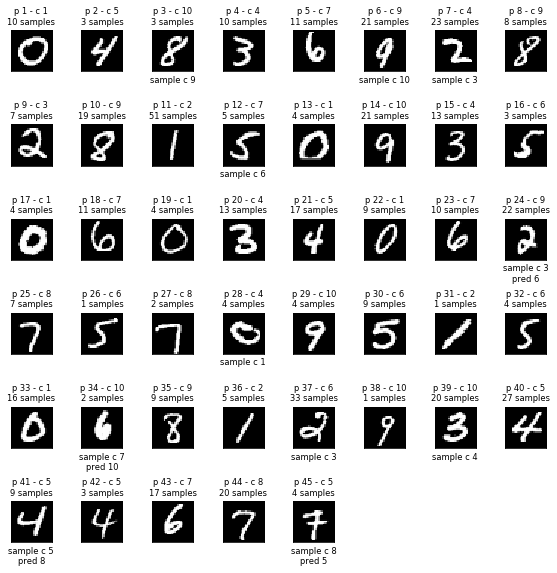

In [25]:
reportl2.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.tight_layout()
reportl2.savefig('closest_images.eps')

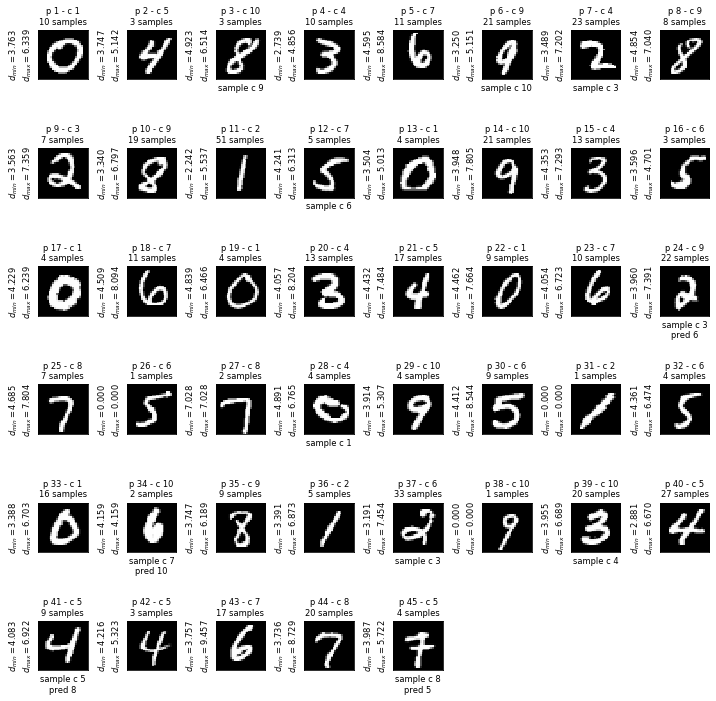

In [26]:
reportl2.closest_images(X_imgs, X, y, show_distances=True)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.tight_layout()

In [27]:
X[train].shape

(500, 2048)

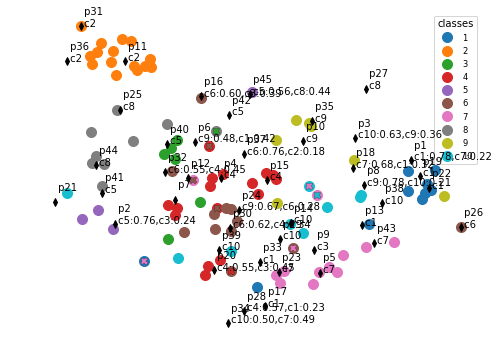

In [28]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False,
               plot_n_samples=100)
fig = plt.gcf()
fig.set_size_inches(8,6)
reportl2.savefig('plot2D_tsne.eps')

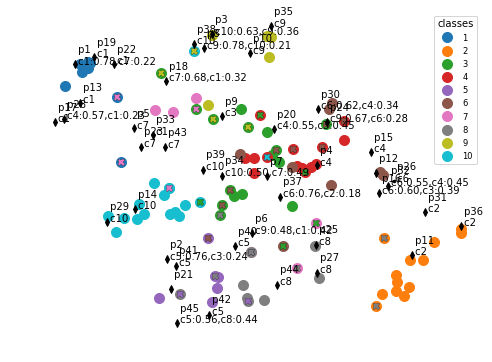

In [29]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', split='test', 
                cluster_limits=False, arrows=False,
                plot_n_samples=100)
fig = plt.gcf()
fig.set_size_inches(8,6)
reportl2.savefig('plot2D_tsne_test.eps')

In [30]:
# preds = reportl2.model.best_estimator_.predict(X)
# misclassified = np.ix_(reportl2.model.best_estimator_.predict(X)!=y)[0].tolist()
# prototype = reportl2.cluster.predict(reportl2.normalize.transform(X))
# ncols = 7
# nrows = int(np.ceil(len(misclassified)/ncols))
# ix = 0
# plt.figure(figsize=(12,5))
# for i in range(nrows):
#     for j in range(ncols):
#         if ix < len(misclassified):
#             miss_ix = misclassified[ix]
#             plt.subplot2grid((nrows, ncols), (i,j))
#             image = X_imgs[miss_ix,:,:]
#             plt.imshow(image, cmap='Greys_r')
#             plt.axis('off')
#             title = 'pred %s - proto %d\n(true %s)'% (preds[miss_ix]+1, prototype[miss_ix]+1, y[miss_ix]+1)
#             plt.title(title)
#             ix+=1
# plt.tight_layout()
# reportl2.savefig('misclassified.eps')

## Concatenating features and prototype compressed features

In [31]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_concat_models'),
        model_list=['l1_cat','l2_cat'],
        n_Cs=10, Cs_lim=(-3,8),
        n_n_clusters=10, n_clusters_lim=(1,5),
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_cat', 'l2_cat'], 'path': './prototype_results/mnist_hparams/analysing_concat_models', 'dataset': <prototype_data.Mnist object at 0x7fcfac963a20>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fcfac963c50>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 10, 'Cs_lim': (-3, 8), 'n_n_clusters': 10, 'n_clusters_lim': (1, 5), 'n_class_weights': 3, 'class_weight_lim': (0.0, 2.0), 'n_shortcut': 1, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/mnist_hparams/analysing_concat_models/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_cat', 'l2_cat']
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   40.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 15.8min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 26.0min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed: 30.6min finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   32.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 13.7min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed: 17.3min finished


### Train/test split 0

In [32]:
reportl1 = Report('analysing_concat_models', models, model='l1_cat', splitter=skf, N=N, directory=results_path)
reportl2 = Report('analysing_concat_models', models, model='l2_cat', splitter=skf, N=N, directory=results_path)

In [33]:
for train, test in skf.split(X, y):
    print('l1',reportl1.model.score(X[test],y[test]),'l2',reportl2.model.score(X[test],y[test]))

l1 0.873 l2 0.8988


#### L1 penalty

In [34]:
reportl1.wc_stats()
reportl1.report(X,y)

Wc sparsity @ tol=0.1 0.9897705078125
Wc mean:  0.0007819409791573643 std:  0.025748524318574186
best Params {'classify__C': 4.641588833612782, 'classify__penalty': 'l1', 'classify__shortcut': 'cat', 'classify__solver': 'saga', 'classify__tol': 0.1, 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 10}
mean acuracy of best cv model:  0.8388679969915668
best model train accuracy:  0.956
holdout test accuracy:  0.873


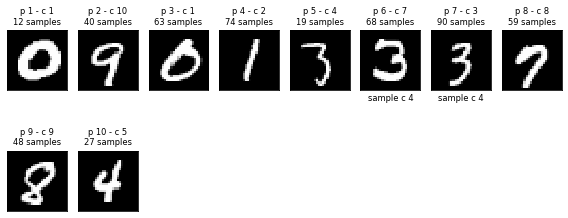

In [35]:
reportl1.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
fig.set_size_inches(8,4)
plt.tight_layout()

proto per class:  [1.50109451 0.93657903 0.67452688 1.03452572 1.07046336 0.86766402
 0.86717093 0.86799982 1.07922163 1.10075409]


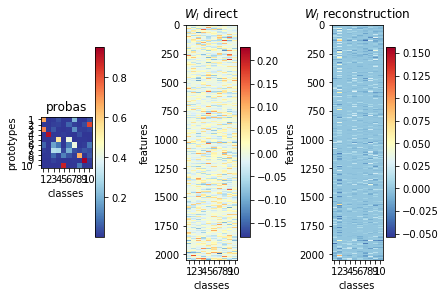

In [36]:
reportl1.visualize_weights()

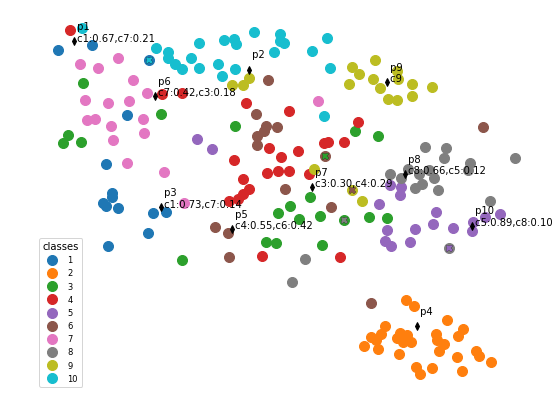

In [37]:
reportl1.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False,
               random_state=random_state)
fig = plt.gcf()
fig.set_size_inches(9,7)
reportl1.savefig('plot2D_tsne.eps')

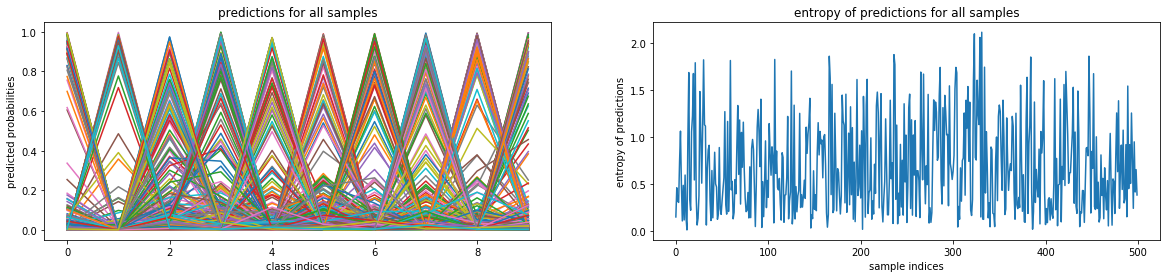

In [38]:
reportl1.entropy_per_sample(X,y)
plt.gcf().set_size_inches(20,4)

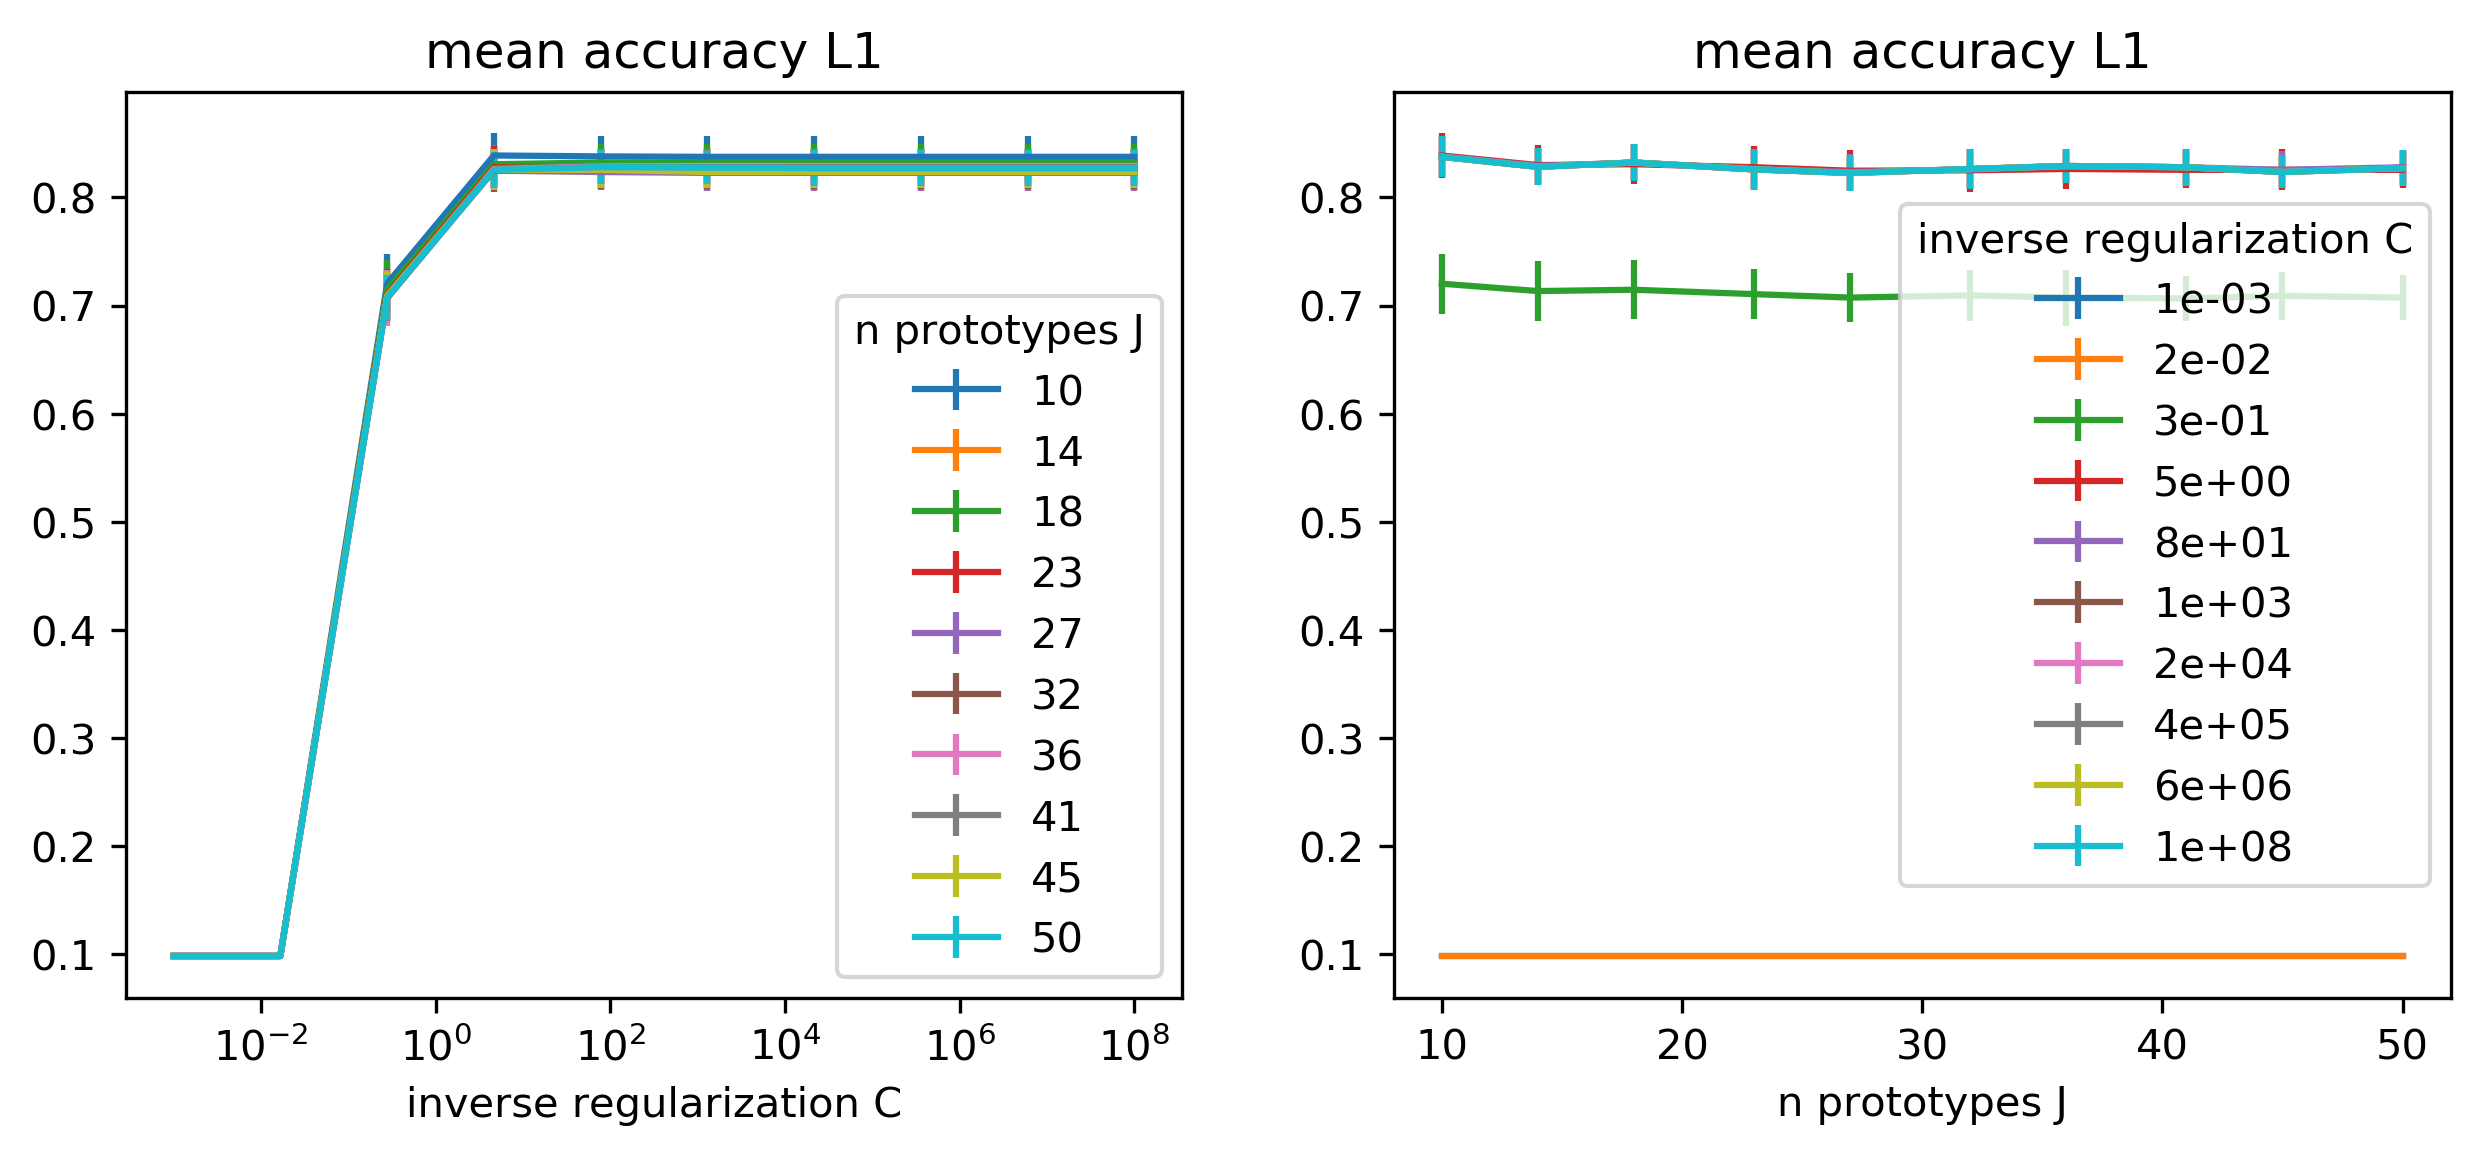

In [39]:
reportl1.main_parameter_grids()

#### L2 penalty

In [40]:
reportl2.wc_stats()
reportl2.report(X,y)

Wc sparsity @ tol=0.1 0.8979248046875
Wc mean:  4.809520837145698e-17 std:  0.061661602369707164
best Params {'classify__C': 4.641588833612782, 'classify__penalty': 'l2', 'classify__shortcut': 'cat', 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 10}
mean acuracy of best cv model:  0.8623897841289146
best model train accuracy:  1.0
holdout test accuracy:  0.8988


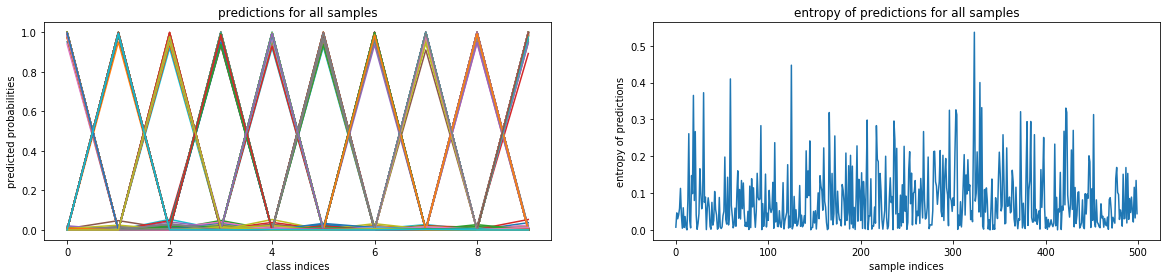

In [41]:
reportl2.entropy_per_sample(X,y)
plt.gcf().set_size_inches(20,4)

proto per class:  [1.71829915 0.99371424 0.43897019 0.81679383 0.96903018 0.91466083
 1.05720923 1.0357466  1.03060798 1.02496776]


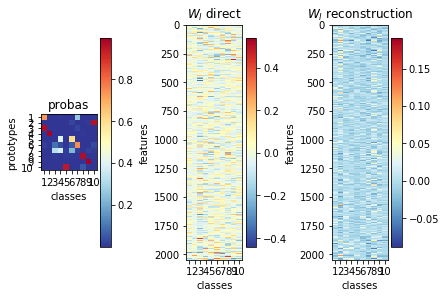

In [42]:
reportl2.visualize_weights()

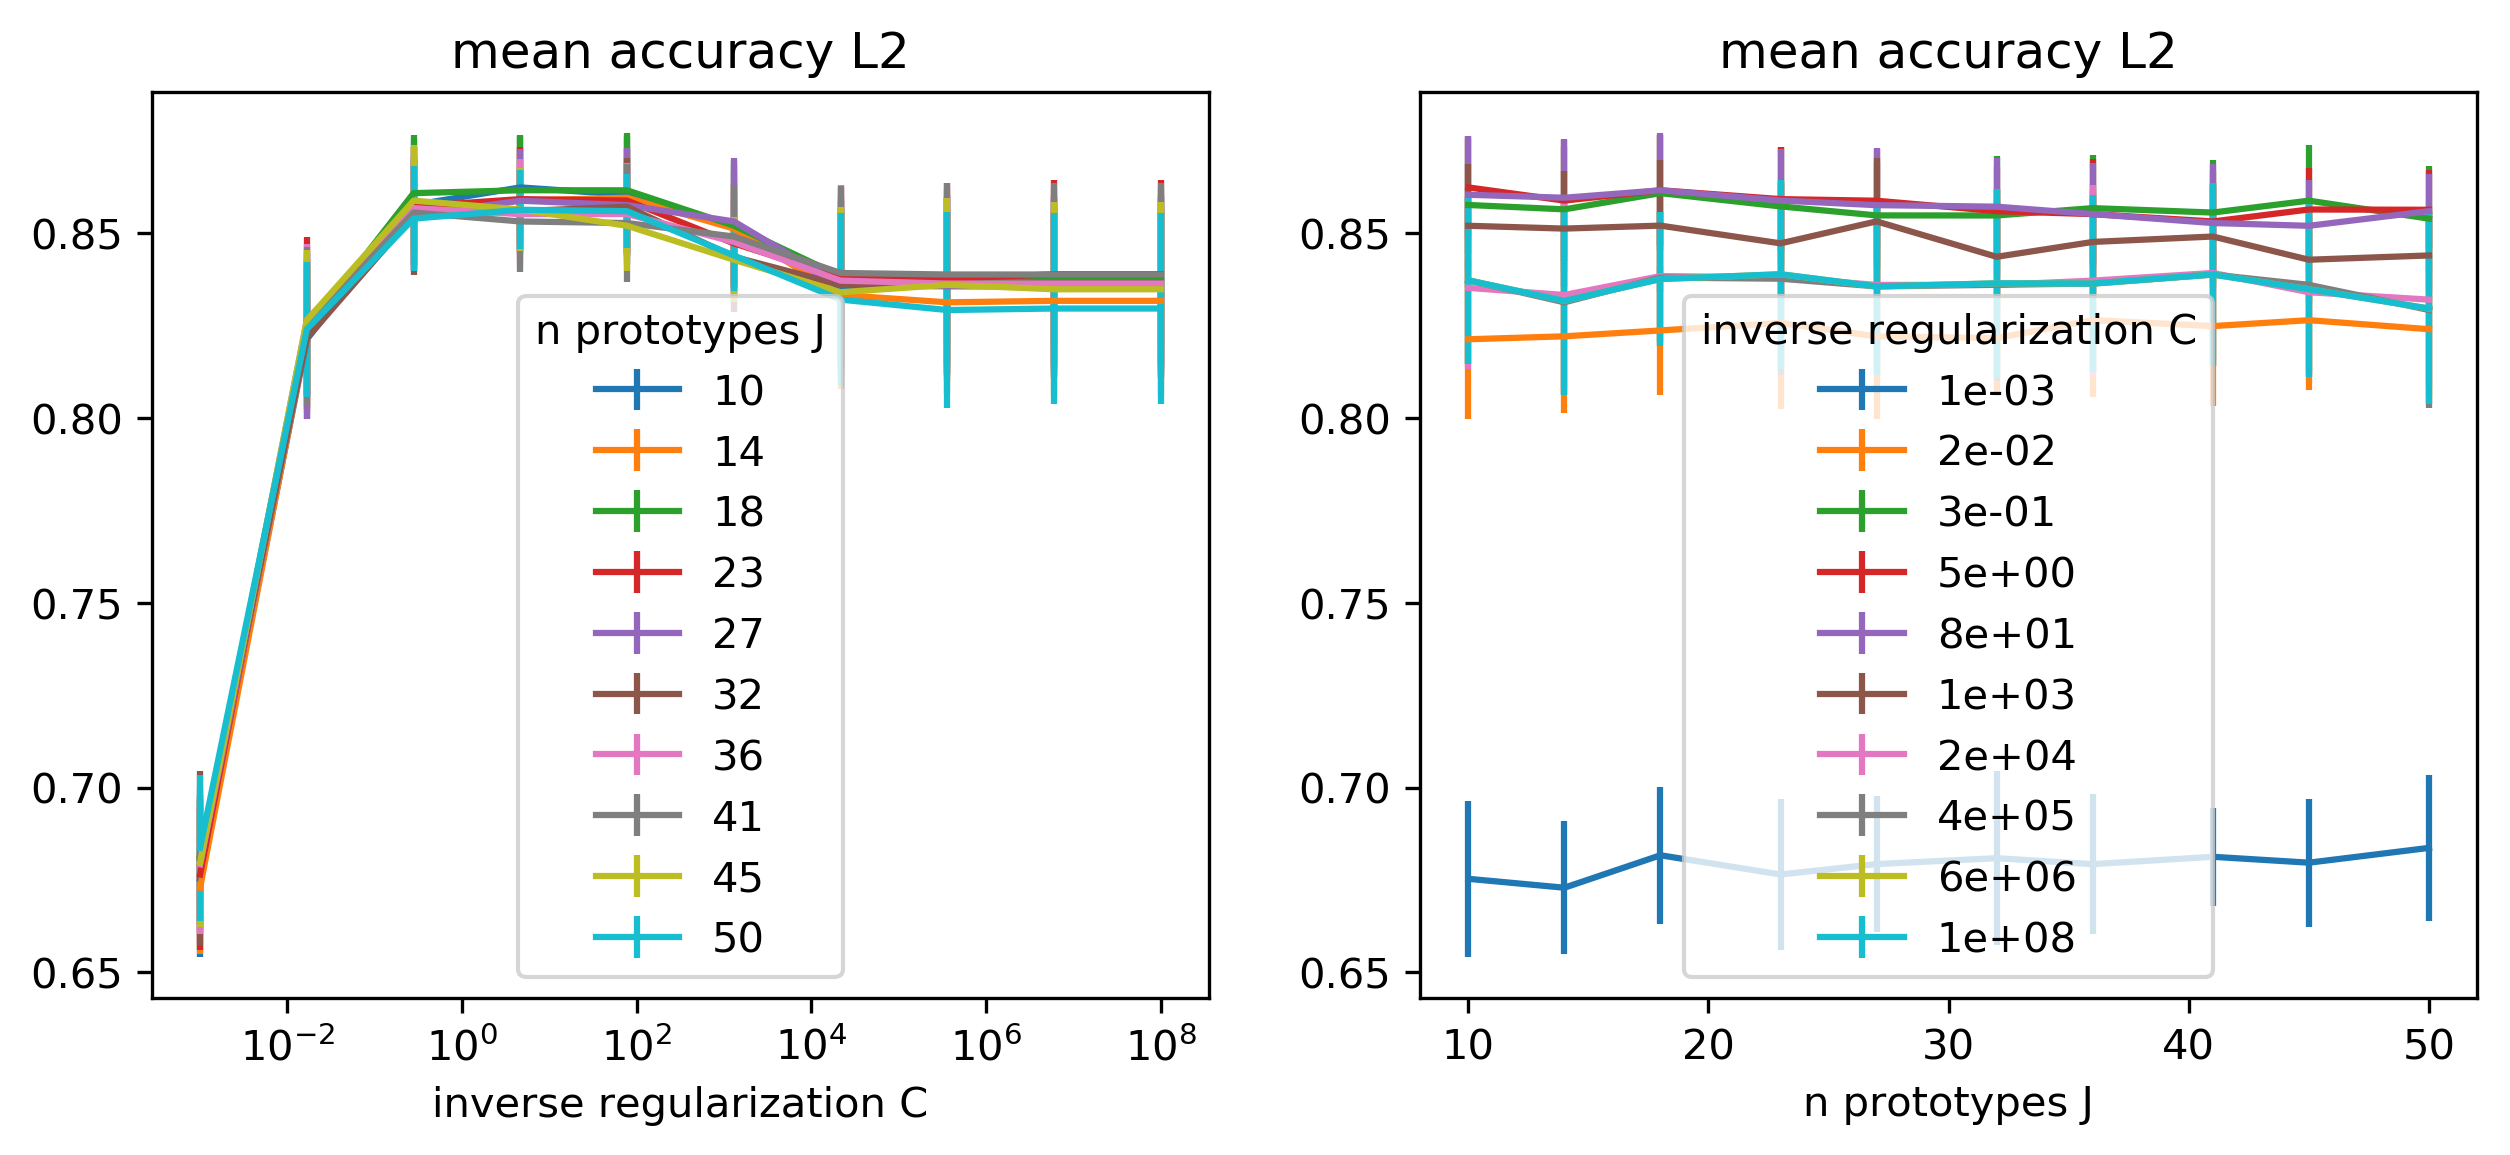

In [43]:
reportl2.main_parameter_grids()

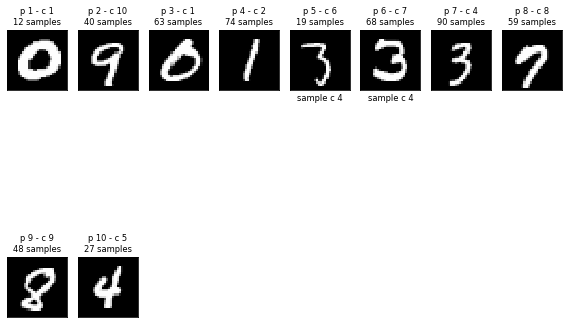

In [44]:
reportl2.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.tight_layout()
reportl2.savefig('closest_images.eps')

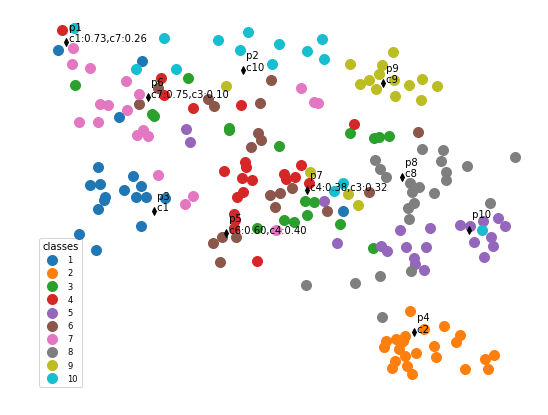

In [45]:
reportl2.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False,
               random_state=random_state)
fig = plt.gcf()
fig.set_size_inches(9,7)
reportl2.savefig('plot2D_tsne.eps')

## Adding a classification loss via using class labels as dimensions
Exploring a smaler range for the parameters already observed. Study class weight param.

In [46]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_class_weight_models'),
        model_list=['l1_classweight','l2_classweight'],
        n_Cs=3, Cs_lim=(2,6),
        n_n_clusters=5, n_clusters_lim=(1,5),
        n_class_weights=5, class_weight_lim=(0,10),
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_classweight', 'l2_classweight'], 'path': './prototype_results/mnist_hparams/analysing_class_weight_models', 'dataset': <prototype_data.Mnist object at 0x7fcfac8b8128>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fcfac8b8048>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 3, 'Cs_lim': (2, 6), 'n_n_clusters': 5, 'n_clusters_lim': (1, 5), 'n_class_weights': 5, 'class_weight_lim': (0, 10), 'n_shortcut': 1, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/mnist_hparams/analysing_class_weight_models/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_classweight', 'l2_classweight']
Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   38.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  6.9min
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergen

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   37.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done 750 out of 750 | elapsed: 11.3min finished


### Train split 0
#### L1

In [47]:
reportl1 = Report('analysing_class_weight_models', models, model='l1_classweight', splitter=skf, N=N, directory=results_path)
reportl2 = Report('analysing_class_weight_models', models, model='l2_classweight', splitter=skf, N=N, directory=results_path)

In [48]:
reportl1.wc_stats()
reportl1.report(X, y)

Wc sparsity @ tol=0.1 0.016000000000000014
Wc mean:  0.09325297573275046 std:  4.908559923741563
best Params {'classify__C': 100.0, 'classify__penalty': 'l1', 'classify__shortcut': 0.0, 'classify__solver': 'saga', 'classify__tol': 0.1, 'classify__use_shortcut': False, 'cluster__class_weight': 7.5, 'cluster__n_clusters': 50}
mean acuracy of best cv model:  0.76091917236082
best model train accuracy:  0.924
holdout test accuracy:  0.8175


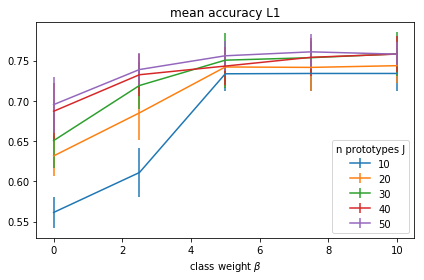

In [49]:
reportl1.parameter_grid(index=['param_cluster__class_weight',],
    columns=['param_cluster__n_clusters'], fix='all')
plt.tight_layout()
reportl1.savefig('class_weight_n_clusters.eps')

#### L2

In [50]:
reportl2.wc_stats()
reportl2.report(X,y)

Wc sparsity @ tol=0.1 0.00666666666666671
Wc mean:  -4.500103993147302e-16 std:  6.048811739670617
best Params {'classify__C': 100.0, 'classify__penalty': 'l2', 'classify__shortcut': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': False, 'cluster__class_weight': 10.0, 'cluster__n_clusters': 30}
mean acuracy of best cv model:  0.7659807012209758
best model train accuracy:  0.906
holdout test accuracy:  0.807


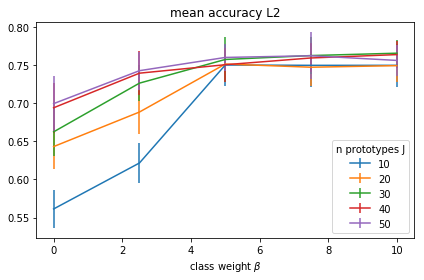

In [51]:
reportl2.parameter_grid(index=['param_cluster__class_weight',],
    columns=['param_cluster__n_clusters'], fix='all')
plt.tight_layout()
reportl2.savefig('class_weight_n_clusters.eps')

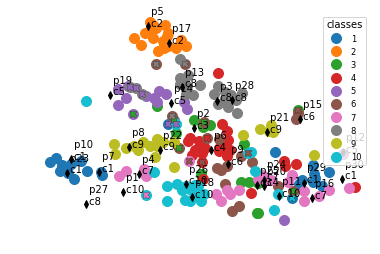

In [52]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', perplexity=30, cluster_limits=False, arrows=False)

In [53]:
reportl2.params()

best parameters:  {'classify__C': 100.0, 'classify__penalty': 'l2', 'classify__shortcut': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': False, 'cluster__class_weight': 10.0, 'cluster__n_clusters': 30}


## Balancing between our model and a simple softmax with a shortcut
Model now has a shorcut from the features to the softmax layer. 
Shorcut value is between 0 (only our model) and 1 (only features+softmax)
Idealy approaching shortcut 1 should get us close to softmax perf.
If we have something better in between that means we can help the softmax.

In [54]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_shortcut_model'),
        model_list=['l1_shortcut', 'l2_shortcut'],
        n_Cs=3, Cs_lim=(2,6),
        n_n_clusters=5, n_clusters_lim=(1,5),
        n_shortcut=5, 
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_shortcut', 'l2_shortcut'], 'path': './prototype_results/mnist_hparams/analysing_shortcut_model', 'dataset': <prototype_data.Mnist object at 0x7fcfa8c88c88>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fcfa8c88be0>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 3, 'Cs_lim': (2, 6), 'n_n_clusters': 5, 'n_clusters_lim': (1, 5), 'n_class_weights': 3, 'class_weight_lim': (0.0, 2.0), 'n_shortcut': 5, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/mnist_hparams/analysing_shortcut_model/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_shortcut', 'l2_shortcut']
Fitting 10 folds for each of 75 candidates, totalling 750 fits


/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   42.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  7.0min
[Parallel(n_jobs=2)]: Done 750 out of 750 | elapsed: 11.8min finished


### Train split 0

In [55]:
reportl1 = Report('analysing_shortcut_model', models, model='l1_shortcut', splitter=skf, N=N,directory=results_path)
reportl2 = Report('analysing_shortcut_model', models, model='l2_shortcut', splitter=skf, N=N,directory=results_path)

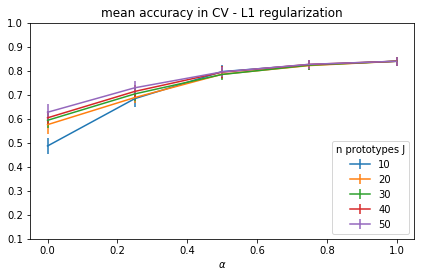

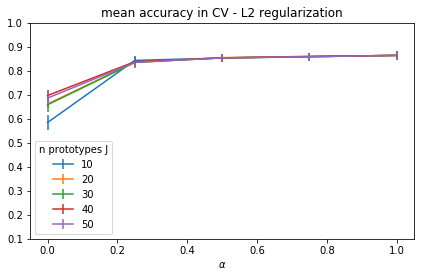

In [56]:
reportl1.parameter_grid(index=['param_classify__shortcut'],
                               columns=['param_cluster__n_clusters'],
                               fix='all')
plt.ylim(0.1,1)
plt.tight_layout()
plt.title('mean accuracy in CV - L1 regularization')
plt.xscale('linear')
reportl1.savefig('shortcut_n_clusters.eps')


reportl2.parameter_grid(index=['param_classify__shortcut'],
                               columns=['param_cluster__n_clusters'],
                               fix='all')
plt.ylim(0.1,1)
plt.tight_layout()
plt.title('mean accuracy in CV - L2 regularization')
plt.xscale('linear')
reportl2.savefig('shortcut_n_clusters.eps')

#### L1

proto per class:  [1.32189736 0.88396035 0.70261986 0.98723737 1.02673549 1.01976647
 1.07728006 0.83637513 1.04160379 1.10252412]
best Params {'classify__C': 10000.0, 'classify__penalty': 'l1', 'classify__shortcut': 1.0, 'classify__solver': 'saga', 'classify__tol': 0.1, 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 10}
mean acuracy of best cv model:  0.8412203357283449
best model train accuracy:  0.962
holdout test accuracy:  0.8737


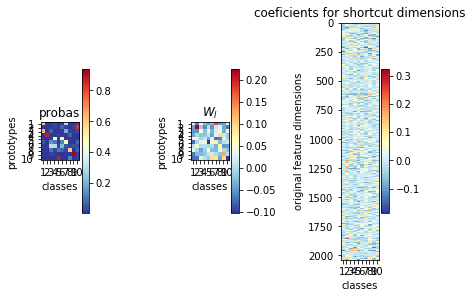

In [57]:
reportl1.visualize_weights()
reportl1.report(X,y)

* Especially for n clsuters = n classes the shortcut helps the most
* hypothesis: 10 clusters is a too low dimensionality, too simple a model. Softmax over the original features is a much more complex model (extra 2048 weights!)

#### L2

proto per class:  [1.85815364 0.99858603 0.45981049 0.48681884 0.9996551  1.15388144
 1.00472222 0.99602356 1.01166712 1.03068157]
best Params {'classify__C': 100.0, 'classify__penalty': 'l2', 'classify__shortcut': 1.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 10}
mean acuracy of best cv model:  0.8656478532908738
best model train accuracy:  1.0
holdout test accuracy:  0.8999


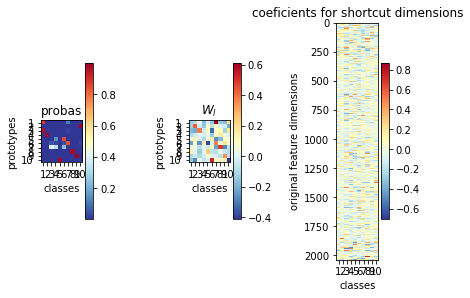

In [58]:
reportl2.visualize_weights()
reportl2.report(X,y)

best parameters:  {'classify__C': 100.0, 'classify__penalty': 'l2', 'classify__shortcut': 1.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 10}


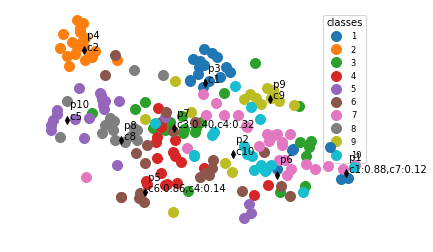

In [59]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30)
reportl2.params()
reportl2.savefig('plot2D_tsne.eps')

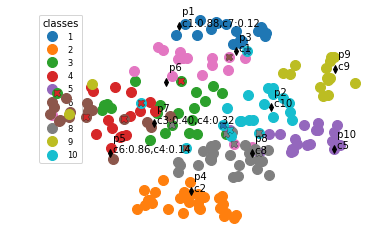

In [60]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30, split='test')
reportl2.savefig('plot2D_tsne_test.eps')

## Class weight and shortcut togheter - do they help eachother?

In [61]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_full_model'),
        model_list=['l1_full', 'l2_full'],
        n_Cs=2, Cs_lim=(2,6),
        n_n_clusters=3, n_clusters_lim=(1,5),
        n_class_weights=3, class_weight_lim=(0,10),
        n_shortcut=5, 
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_full', 'l2_full'], 'path': './prototype_results/mnist_hparams/analysing_full_model', 'dataset': <prototype_data.Mnist object at 0x7fcfabe82550>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fcfabe82908>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 2, 'Cs_lim': (2, 6), 'n_n_clusters': 3, 'n_clusters_lim': (1, 5), 'n_class_weights': 3, 'class_weight_lim': (0, 10), 'n_shortcut': 5, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/mnist_hparams/analysing_full_model/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_full', 'l2_full']
Fitting 10 folds for each of 90 candidates, totalling 900 fits


/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   46.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  8.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 14.2min
[Parallel(n_jobs=2)]: Done 900 out of 900 | elapsed: 16.2min finished


### Train split 0
#### L1

In [62]:
reportl1 = Report('analysing_full_model', models, model='l1_full', splitter=skf, N=N, directory=results_path)
reportl2 = Report('analysing_full_model', models, model='l2_full', splitter=skf, N=N, directory=results_path)

In [63]:
n_clusters = np.unique(reportl1.model.cv_results_['param_cluster__n_clusters'].data)

In [64]:
ts = []
terrs = []
for n in n_clusters:
    df, t, terr = reportl1.parameter_grid(
        index=['param_classify__shortcut'],
        columns=['param_cluster__class_weight'], 
        fix=dict(param_cluster__n_clusters=n, 
                 param_classify__C='best'),
        plot=False)
    ts.append(t)
    terrs.append(terr)

- when shortcut is strong, class weight does not matter 


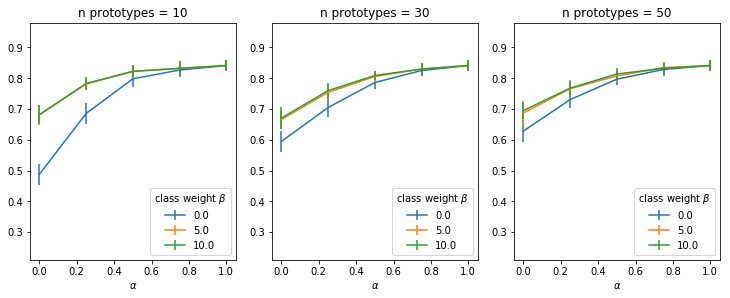

In [65]:
plt.figure(figsize=(10,4))
for i, t in enumerate(ts): 
    ax = plt.subplot(1,3,i+1)
    plt.title('n prototypes = %d' % n_clusters[i])
    t.plot(ax=ax, style=[':d',':.',':+']*20,yerr=terrs[i])
    plt.xscale('log')
    ax.set_xlabel(transform_label(ax.get_xlabel()))
    ax.set_xlabel(r'$\alpha$')
    new_title = transform_label(ax.get_legend().get_title().get_text())
    plt.legend(title=r'class weight $\beta$', loc='lower right')
    plt.ylim(0.21,0.98)
    plt.xscale('linear')
plt.tight_layout(pad=0.2,w_pad=1)
reportl1.savefig('shortcut_class_weight.eps')

#### L2

In [66]:
n_clusters = np.unique(reportl2.model.cv_results_['param_cluster__n_clusters'].data)

In [67]:
ts = []
terrs = []
for n in n_clusters:
    df, t, terr = reportl2.parameter_grid(
        index=['param_classify__shortcut'],
        columns=['param_cluster__class_weight'], 
        fix=dict(param_cluster__n_clusters=n, 
                 param_classify__C='best'),
            plot=False)

    ts.append(t)
    terrs.append(terr)

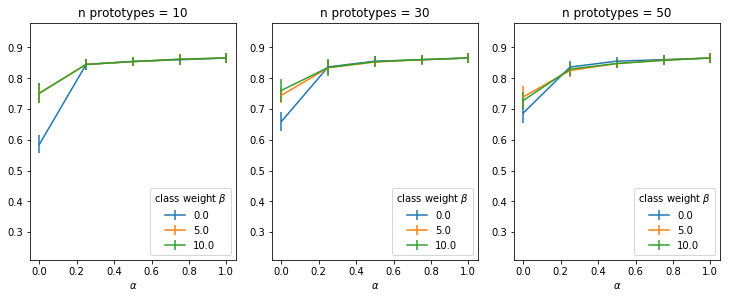

In [68]:
plt.figure(figsize=(10,4))
for i, t in enumerate(ts): 
    ax = plt.subplot(1,3,i+1)
    plt.title('n prototypes = %d' % n_clusters[i])
    t.plot(ax=ax, style=[':d',':.',':+']*20,yerr=terrs[i])
    plt.xscale('log')
    ax.set_xlabel(transform_label(ax.get_xlabel()))
    ax.set_xlabel(r'$\alpha$')
    new_title = transform_label(ax.get_legend().get_title().get_text())
    plt.legend(title=r'class weight $\beta$', loc='lower right')
    plt.ylim(0.21,0.98)
    plt.xscale('linear')
plt.tight_layout(pad=0.2,w_pad=1)
reportl2.savefig('shortcut_class_weight.eps')

best parameters:  {'classify__C': 100.0, 'classify__penalty': 'l2', 'classify__shortcut': 1.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 10}


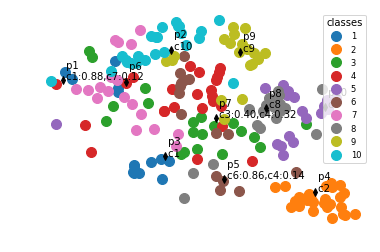

In [69]:
reportl2.plot2D(X,y, method='tsne', perplexity=32, random_state=random_state)
reportl2.params()

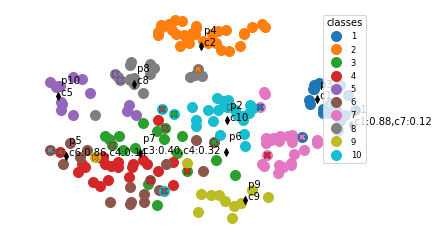

In [70]:
reportl2.plot2D(X,y, method='tsne', perplexity=35, split='test', random_state=random_state)